In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential

In [ ]:
train_df = pd.read_csv('../input/plant-pathology-2020-fgvc7/train.csv')
test_df = pd.read_csv('../input/plant-pathology-2020-fgvc7/test.csv')

In [ ]:
train_df.head()

In [ ]:
train_df['label'] = train_df.apply(lambda x: np.argmax(x[1:]),axis=1)

In [ ]:
train_df.head()

In [ ]:
from PIL import Image
img = Image.open('../input/plant-pathology-2020-fgvc7/images/Train_0.jpg')
nparr  = np.asarray(img)

In [ ]:
nparr.shape

In [ ]:
import os
label_encode = {0:"healthy",1:"multiple_diseases",2:"rust",3:"scab"}




In [ ]:
train_df.shape

In [ ]:
train_df.iloc[0]['image_id']

In [ ]:
from sklearn.model_selection import train_test_split

train_df,validate_df = train_test_split(train_df,test_size=0.2)

In [ ]:
new_img_size = (224,224)

In [ ]:
img = Image.open(f'../input/plant-pathology-2020-fgvc7/images/{train_df.iloc[0]["image_id"]}.jpg')
img=img.resize(new_img_size)
images_train = np.array([np.asarray(img)])

for i in range(1,train_df.shape[0]):
    img = Image.open(f'../input/plant-pathology-2020-fgvc7/images/{train_df.iloc[i]["image_id"]}.jpg')
    img = img.resize(new_img_size)
    images_train = np.concatenate((images_train,np.array([np.asarray(img)])),axis=0)


In [ ]:
img = Image.open(f'../input/plant-pathology-2020-fgvc7/images/{validate_df.iloc[0]["image_id"]}.jpg')
img=img.resize(new_img_size)
images_validate = np.array([np.asarray(img)])
for i in range(1,validate_df.shape[0]):
    img = Image.open(f'../input/plant-pathology-2020-fgvc7/images/{validate_df.iloc[i]["image_id"]}.jpg')
    img = img.resize(new_img_size)
    images_validate = np.concatenate((images_validate,np.array([np.asarray(img)])),axis=0)

In [ ]:
img = Image.open(f'../input/plant-pathology-2020-fgvc7/images/{test_df.iloc[0]["image_id"]}.jpg')
img=img.resize(new_img_size)
images_test = np.array([np.asarray(img)])
for i in range(1,test_df.shape[0]):
    img = Image.open(f'../input/plant-pathology-2020-fgvc7/images/{test_df.iloc[i]["image_id"]}.jpg')
    img = img.resize(new_img_size)
    images_test = np.concatenate((images_test,np.array([np.asarray(img)])),axis=0)

In [ ]:
print("Training set is of shape : ",images_train.shape)
print("Validation set is of shape : ",images_validate.shape)
print("Test set is of shape : ",images_test.shape)

## Model building

Lets start with a base CNN model

In [ ]:
model = Sequential([
    layers.Rescaling(1./255.,input_shape=(224,224,3)),
    layers.Conv2D(8,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Conv2D(16,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(4,activation='softmax'),   
])
model.build()

In [ ]:
model.compile(
    optimizer='adam',
    loss = tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
batch_size = 32
epochs = 15

model.fit(
    images_train,
    train_df['label'],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(images_validate,validate_df['label'])
)

In [ ]:
data_augmentaion = Sequential([
    layers.RandomRotation(factor=(-0.2,0.2),seed = 123),
    layers.RandomZoom(0.1),
])

In [ ]:
model = Sequential([
    layers.Rescaling(1./255.,input_shape=(224,224,3)),
    data_augmentaion,
    layers.Conv2D(8,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Conv2D(16,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D(2,2),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(256,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dense(4,activation='softmax'),   
])
model.build()

In [1]:
model.compile(
    optimizer='adam',
    loss = tf.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

batch_size = 32
epochs = 50

history = model.fit(
    images_train,
    train_df['label'],
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(images_validate,validate_df['label'])
)

NameError: name 'model' is not defined

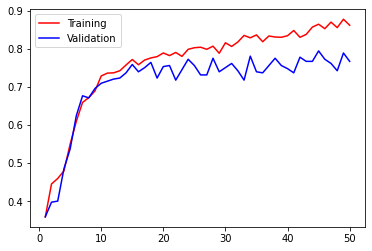

In [23]:
train_acc = history.history['accuracy']
validate_acc = history.history['val_accuracy']
epoch_ = range(1,epochs+1)

plt.plot(epoch_,train_acc,'r',label='Training')
plt.plot(epoch_,validate_acc,'b',label='Validation')
plt.legend()
plt.show()

In [24]:
predictions = model.predict(images_test)

In [25]:
predictions.shape

(1821, 4)

In [26]:
predictions_df = pd.DataFrame(np.round(predictions,2))
submission_df = pd.concat([test_df,predictions_df],axis=1)

In [27]:
submission_df.head()

,image_id,0,1,2,3
0,Test_0,0.00,0.03,0.97,0.00
1,Test_1,0.00,0.01,0.99,0.00
2,Test_2,0.12,0.00,0.00,0.88
3,Test_3,0.85,0.00,0.02,0.12
4,Test_4,0.00,0.00,1.00,0.00


In [28]:
submission_df.rename(columns={k:label_encode[k] for k in range(0,4)}).to_csv("submission.csv",index=False)